### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

print(f'Versão Pandas: {pd.__version__}')
print(f'Versão Numpy: {np.__version__}')

Versão Pandas: 1.0.5
Versão Numpy: 1.17.4


### Bibliotecas de visualização

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use(['seaborn'])

print(f'Versão Seaborn: {sns.__version__}')
print(f'Versão Matplotlib: {matplotlib.__version__}')

Versão Seaborn: 0.10.1
Versão Matplotlib: 3.2.1


### Carregamento dos dados: MNIST

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

In [4]:
X, y = mnist['data'], mnist['target']

print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (70000, 784)
Shape y: (70000,)


### Exemplo

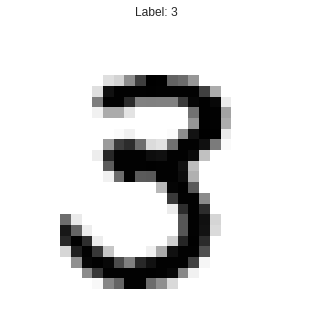

In [5]:
idx = 65356
some_digits = X[idx]
some_digits_image = some_digits.reshape(28, 28)

plt.imshow(some_digits_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.title(f'Label: {str(y[idx])}')
plt.axis('off')
plt.show()

### Mais alguns dígitos

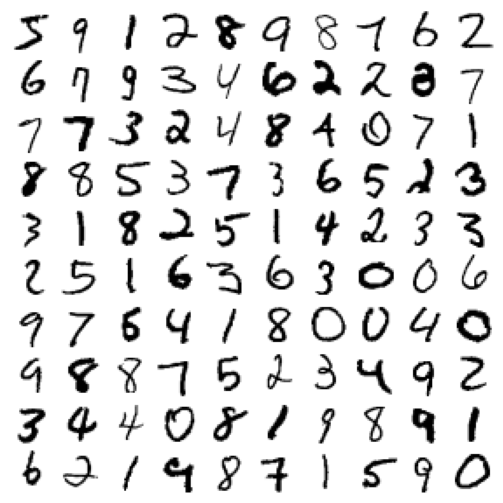

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis('off')
    
    
    

plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

### Separação dos dados

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape:  {X_test.shape}')
print(f'y_test shape:  {y_test.shape}')

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape:  (10000, 784)
y_test shape:  (10000,)


### Embaralhando os dados

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Treinando um classificador binário para o dígito 3

In [9]:
y_train_3 = (y_train == 3)
y_test_3  = (y_test == 3)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_3)

sgd_clf.predict([some_digits])

array([ True])

### Medidas de desempenho

#### Implementando a validação cruzada

In [11]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, random_state=42)
scores = []

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_3[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    scores.append(n_correct/len(y_pred))
    
print(scores)   
print(f'Score: {np.mean(scores)}')

[0.93575, 0.9575, 0.96785]
Score: 0.9537


#### Validação cruzada

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring='accuracy')

array([0.93575, 0.9575 , 0.96785])

#### Gerando previsões

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

#### Matriz de confusão

In [14]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_3, y_train_pred))

[[52048  1821]
 [  957  5174]]


#### Precisão e recall (revocação ou sensibilidade)

In [15]:
from sklearn.metrics import precision_score, recall_score

print(f'Precisão: {precision_score(y_train_3, y_train_pred)}')
print(f'Recall: {recall_score(y_train_3, y_train_pred)}')

Precisão: 0.7396711937097927
Recall: 0.8439080084814875


#### F1-Score

In [16]:
from sklearn.metrics import f1_score

print(f'F1: {f1_score(y_train_3, y_train_pred)}')

F1: 0.7883589821727869


#### Compensação da Precisão/Recall

##### Previsões com base no limiar (threshold)

In [17]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([287907.24208794])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [19]:
threshold = 400000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#####  Precision recall curve

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method='decision_function')
y_scores

array([ -440258.79224352,  -110182.2744499 ,   110851.11377591, ...,
        -771874.19088805,   340015.02249109, -1131002.69401493])

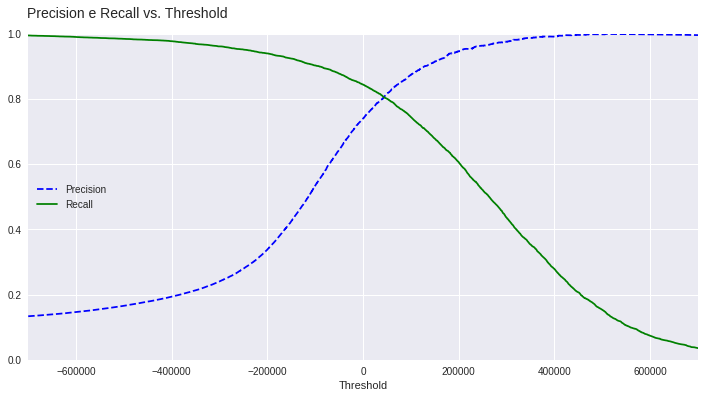

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plt.figure(figsize=[12, 6])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Precision e Recall vs. Threshold', y=1.03, size=14, loc='left', x=-0.002)
plt.xlim([-700000, 700000])
plt.show()

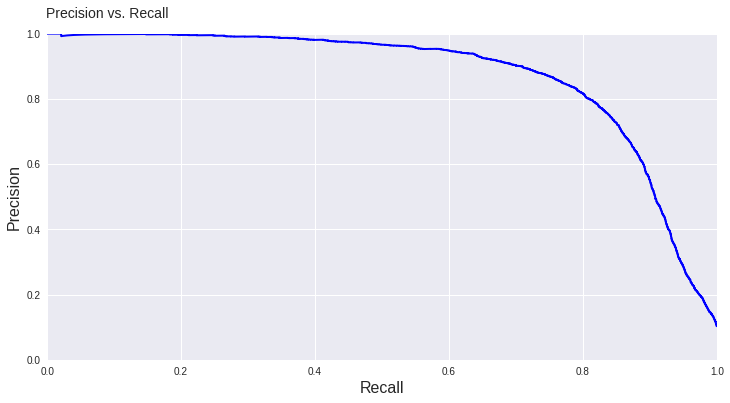

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=[12, 6])
plot_precision_vs_recall(precisions, recalls)
plt.title('Precision vs. Recall', y=1.03, size=14, loc='left', x=-0.002)
plt.show()

### Curva ROC

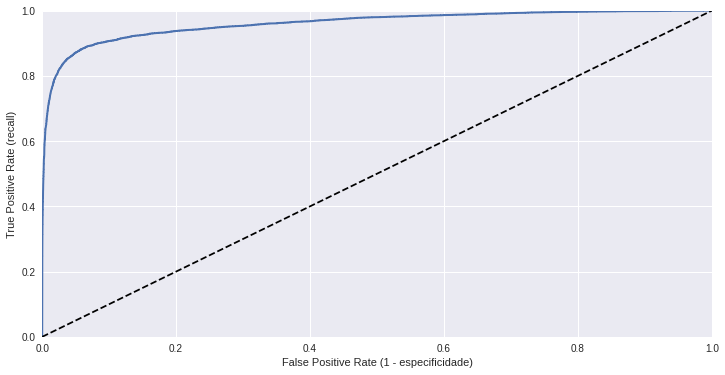

In [23]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (1 - especificidade)')
    plt.ylabel('True Positive Rate (recall)')
    

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
plt.figure(figsize=[12, 6])
plot_roc_curve(fpr, tpr)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9605403703231576

#### Comparando modelos

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3, method='predict_proba')

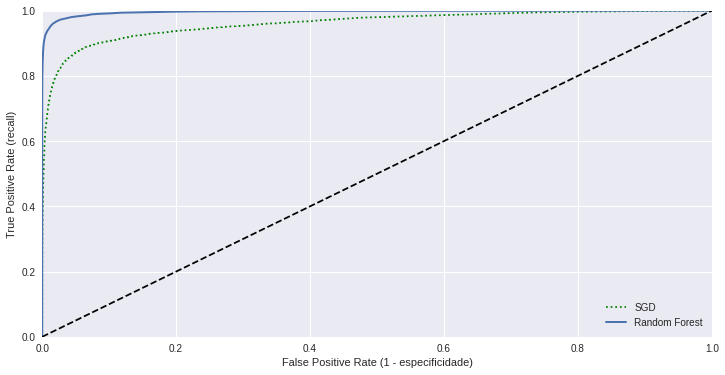

In [26]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)

plt.figure(figsize=[12, 6])
plt.plot(fpr, tpr, 'g:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [27]:
roc_auc_score(y_train_3, y_scores_forest)

0.9962849323793918

In [28]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)

In [29]:
precision_score(y_train_3, y_train_pred_forest)

0.9939934121294323

In [30]:
recall_score(y_train_3, y_train_pred_forest)

0.8367313651932801

### Classificação multiclasse


In [31]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digits])

array([3], dtype=int8)

In [32]:
some_digits_score = sgd_clf.decision_function([some_digits])
some_digits_score

array([[-491345.74055367, -614034.77854615, -604621.9319943 ,
         187350.81762959, -301359.0658021 ,  -88767.26265431,
        -995542.26615363, -823062.79695886, -173128.63586597,
        -209564.41201171]])

In [33]:
np.argmax(some_digits_score)

3

In [34]:
sgd_clf.classes_[3]

3

### OneVsOne (OVO)

In [35]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digits])

array([3], dtype=int8)

In [36]:
len(ovo_clf.estimators_)

45

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87665, 0.87965, 0.8631 ])

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9104 , 0.91135, 0.90785])

### Análise de erro

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [40]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5726,    2,   23,   11,   11,   52,   51,    9,   35,    3],
       [   2, 6468,   43,   23,    5,   38,    7,   11,  137,    8],
       [  57,   43, 5326,  101,   85,   21,   83,   55,  174,   13],
       [  47,   40,  143, 5362,    2,  221,   33,   62,  134,   87],
       [  16,   28,   39,    9, 5377,   10,   48,   31,   97,  187],
       [  63,   39,   38,  182,   78, 4623,  111,   35,  163,   89],
       [  33,   24,   47,    1,   43,   99, 5625,    7,   39,    0],
       [  24,   19,   66,   25,   57,   10,    8, 5830,   15,  211],
       [  53,  144,   74,  155,   16,  173,   55,   26, 5003,  152],
       [  43,   34,   26,   89,  166,   39,    3,  221,   76, 5252]])

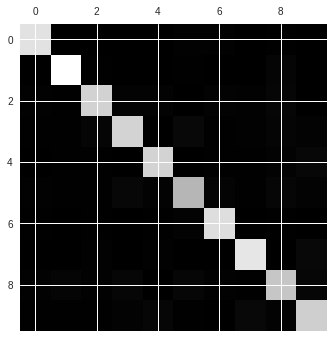

In [41]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

#### Plotando apenas os erros

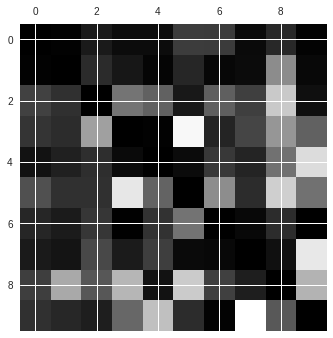

In [42]:
rows_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sum
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Analisando erros individualmente

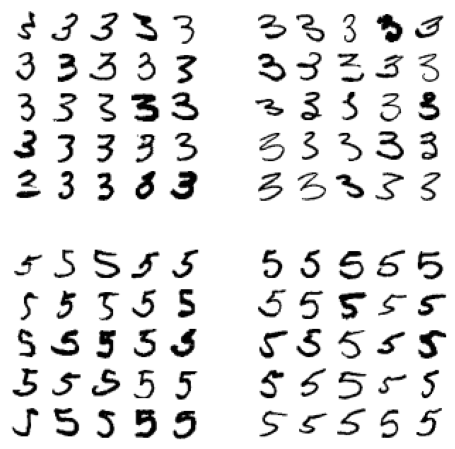

In [43]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel

In [44]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digits])

array([[False,  True]])

In [ ]:
y_train_knn = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn, average='macro')